### Importing Libraries

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier
import lime
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score,precision_score,recall_score,f1_score
from imblearn.over_sampling import SMOTE
shap.initjs()

**Dataset Link: https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud**

### Loading the dataset

In [7]:
data=pd.read_csv('card_transdata.csv')

### Data Exploration

#### How data looks like

In [8]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


#### the number of rows and columns present in the dataset

In [9]:
data.shape

(1000000, 8)

#### Examining the dtype, column-name, non-null coount of the dataset

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


**There are inconsistencies found in various columns in the data type sucy as repeat retailer should be int**

In [11]:
data.columns

Index(['distance_from_home', 'distance_from_last_transaction',
       'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip',
       'used_pin_number', 'online_order', 'fraud'],
      dtype='object')

#### Removing the inconsistencies present inside various columns

In [12]:
cols=data.columns[3:]
for col in cols:
    data[col]=data[col].astype(int)

#### Five variable summary of the dataset

In [13]:
data.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


**After analyzing the descriptive statistics of the dataset it can be seen that standard deviation is greater than mean, concluding data is highly dispersed**

## **Data Preprocessing**

#### Checking the missing values from the dataset

In [14]:
data.isna().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

#### Checking the number of duplicate records from the dataset

In [15]:
data.duplicated().sum()

0

### **Checking the outliers**

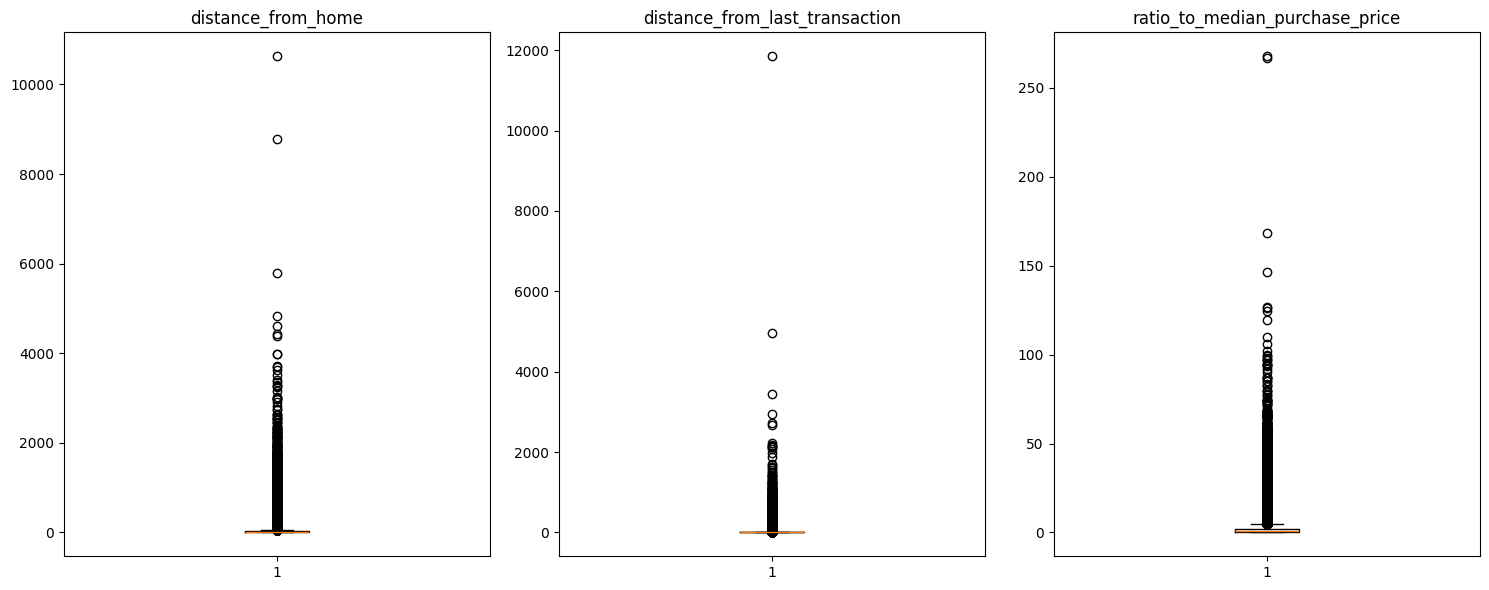

In [16]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
# Create box plots
axs[0].boxplot(data['distance_from_home'])
axs[0].set_title('distance_from_home')
axs[1].boxplot(data['distance_from_last_transaction'])
axs[1].set_title('distance_from_last_transaction')
axs[2].boxplot(data['ratio_to_median_purchase_price'])
axs[2].set_title('ratio_to_median_purchase_price')
# Layout so plots do not overlap
fig.tight_layout()
# Show the plot
plt.show()

## **Taking care of outliers by capping outliers**

#### Capping outliers from the Distance_from_home column

In [17]:
q1=data['distance_from_home'].quantile(0.25)
q3=data['distance_from_home'].quantile(0.5)
iqr=q3-q1
lower_fence=q1-(1.5*iqr)
upper_fence=q3+(1.5*iqr)
data['distance_from_home']=np.where(data['distance_from_home']<lower_fence,lower_fence,data['distance_from_home'])
data['distance_from_home']=np.where(data['distance_from_home']>upper_fence,upper_fence,data['distance_from_home'])

#### Capping outliers from  distance_from_last_transaction

In [18]:
q1=data['distance_from_last_transaction'].quantile(0.25)
q3=data['distance_from_last_transaction'].quantile(0.5)
iqr=q3-q1
lower_fence=q1-(1.5*iqr)
upper_fence=q3+(1.5*iqr)
data['distance_from_last_transaction']=np.where(data['distance_from_last_transaction']<lower_fence,lower_fence,data['distance_from_last_transaction'])
data['distance_from_last_transaction']=np.where(data['distance_from_last_transaction']>upper_fence,upper_fence,data['distance_from_last_transaction'])

### Capping outliers from ratio_to_median_purchase_price

In [19]:
q1=data['ratio_to_median_purchase_price'].quantile(0.25)
q3=data['ratio_to_median_purchase_price'].quantile(0.5)
iqr=q3-q1
lower_fence=q1-(1.5*iqr)
upper_fence=q3+(1.5*iqr)
data['ratio_to_median_purchase_price']=np.where(data['ratio_to_median_purchase_price']<lower_fence,lower_fence,data['ratio_to_median_purchase_price'])
data['ratio_to_median_purchase_price']=np.where(data['ratio_to_median_purchase_price']>upper_fence,upper_fence,data['ratio_to_median_purchase_price'])

#### Visualizing Box plots after capping outliers

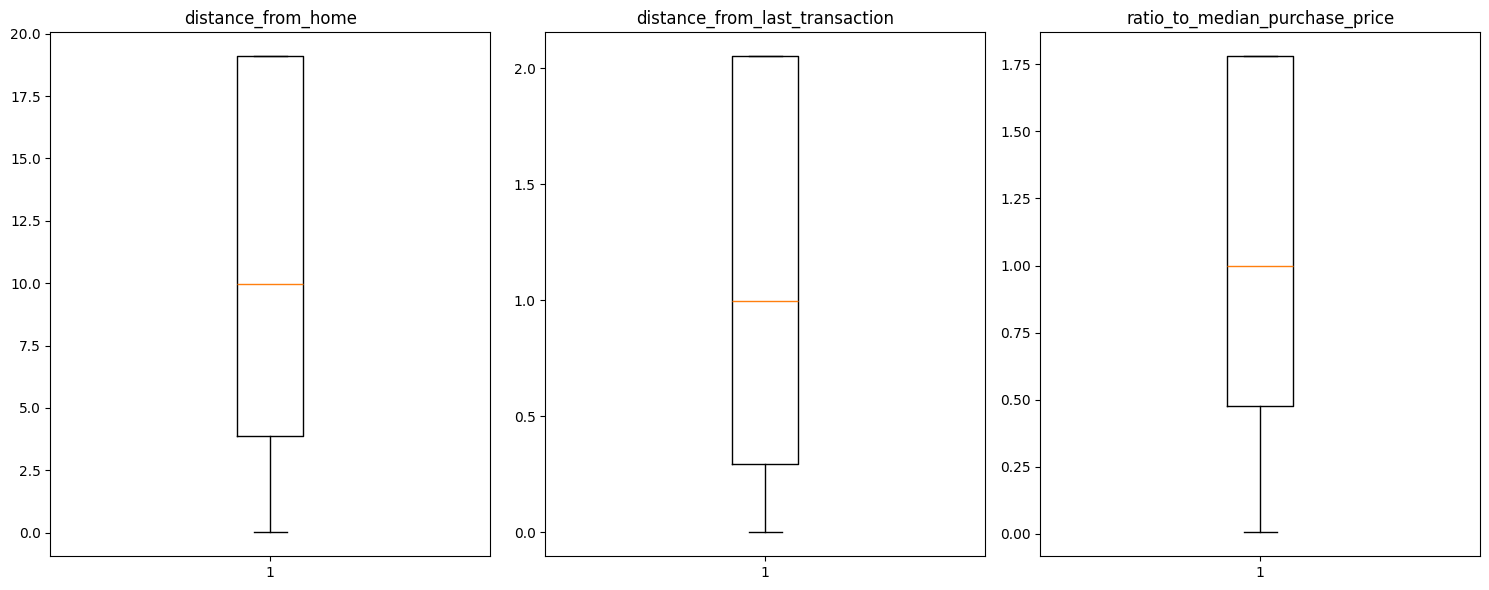

In [20]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
# Create box plots
axs[0].boxplot(data['distance_from_home'])
axs[0].set_title('distance_from_home')
axs[1].boxplot(data['distance_from_last_transaction'])
axs[1].set_title('distance_from_last_transaction')
axs[2].boxplot(data['ratio_to_median_purchase_price'])
axs[2].set_title('ratio_to_median_purchase_price')
# Layout so plots do not overlap
fig.tight_layout()
# Show the plot
plt.show()

## **EDA (Exploratory Data Analysis)**

### Target column Distribution

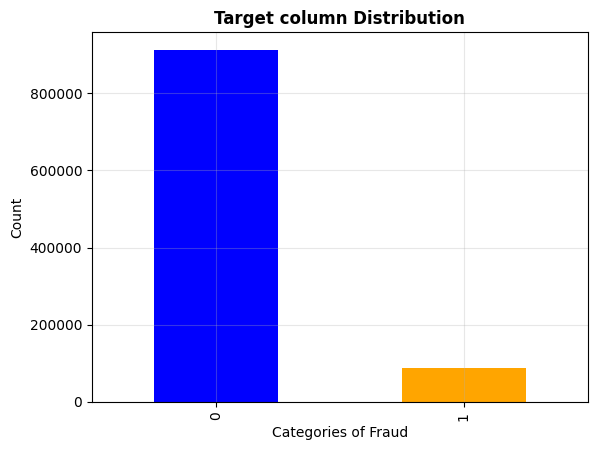

In [21]:
fraud_distribution=data['fraud'].value_counts()
data['fraud'].value_counts().plot(kind='bar',color=['blue','orange'])
plt.title("Target column Distribution",weight='bold')
plt.xlabel("Categories of Fraud")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()


***After analysing the distribution of the target column it can be concluded that data is highly imbalanced in nature, necessary steps should be taken for balancing the dataset, before training data on this imbalanced dataset. If not taken care could add bias in the results and prevents the model from getting the generalized predictions***

### Checking the Distribution of the Distance from home column

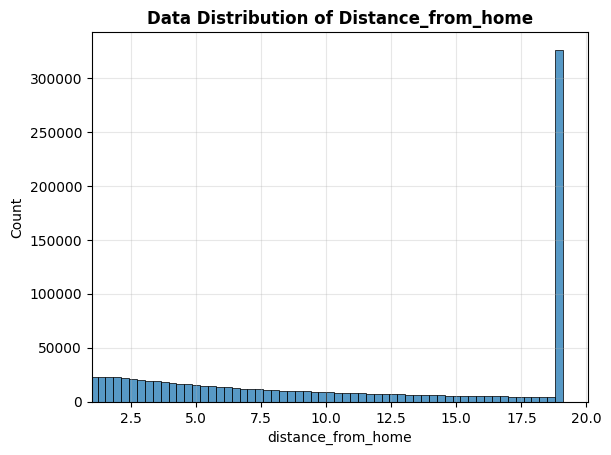

In [22]:
sns.histplot(data, x='distance_from_home')
plt.title("Data Distribution of Distance_from_home", weight='bold')
plt.grid(alpha=0.3)
plt.xlim(left=1)
plt.show()

***to see whether features of that distribution differ across the target variables in the dataset***

### Distribution of Distance_from_last_transaction

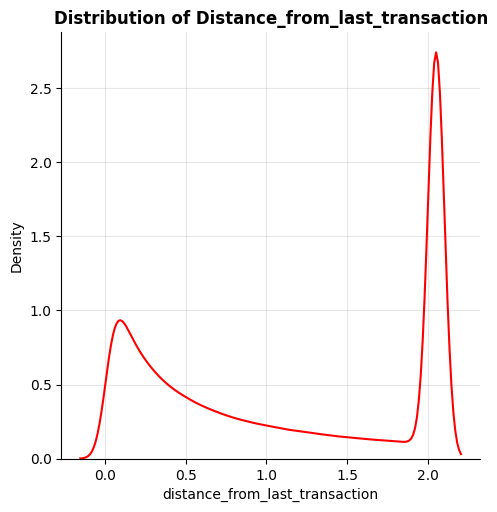

In [23]:
sns.displot(data, x="distance_from_last_transaction",color='red',kind="kde")
plt.title("Distribution of Distance_from_last_transaction",weight='bold')
plt.grid(alpha=0.3)
plt.show()


### Data distribution of ratio_to_median_purchase_price

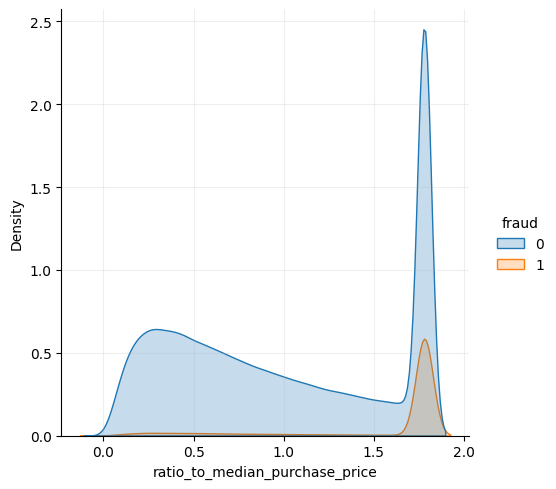

In [24]:
sns.displot(data, x="ratio_to_median_purchase_price",hue='fraud', kind="kde",fill=True)
plt.title("KDE plot for ratio_to_median_purchase_price distribution",weight='bold')
plt.grid(alpha=0.2)
plt.title("")
plt.show()

### Barchart for understanding distribution of people based on Repeat retailer

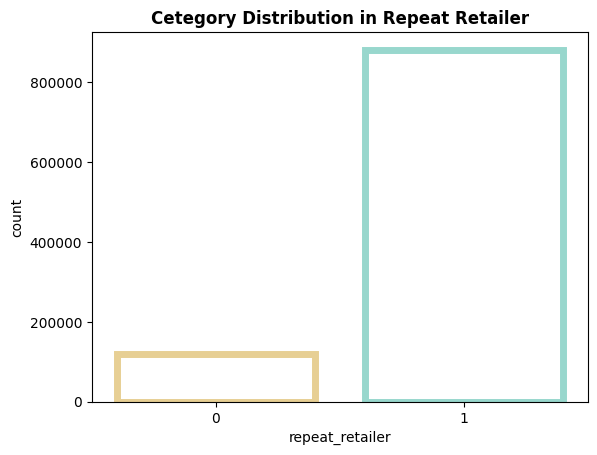

In [25]:
sns.countplot(x ='repeat_retailer', data = data,color="salmon", facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("BrBG", 2))
plt.title("Cetegory Distribution in Repeat Retailer", weight='bold')
plt.show()

### Pie-chart for understanding percentage of consumers used chips

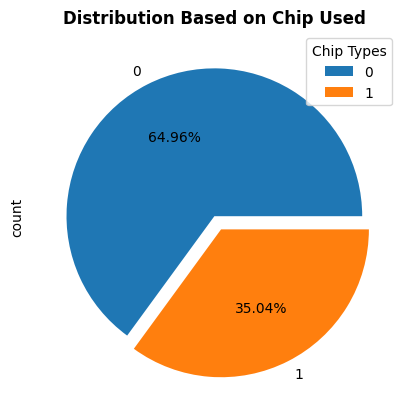

<Figure size 800x600 with 0 Axes>

In [26]:
data['used_chip'].value_counts().plot(kind='pie', autopct='%.2f%%', explode=[0, 0.1])

# Additional customizations
plt.title("Distribution Based on Chip Used", weight='bold')
plt.legend(title='Chip Types', loc='upper right')
plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.show()

### Distribution based on use of pin number

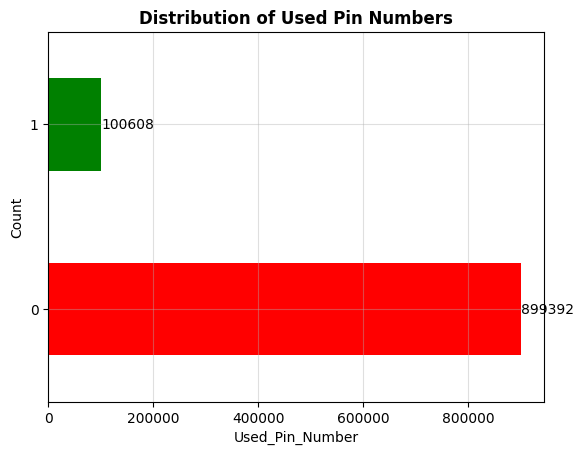

In [27]:
data['used_pin_number'].value_counts().plot(kind='barh', color=['red', 'green'])
plt.grid(alpha=0.4)
for p in plt.gca().patches:
    plt.gca().text(p.get_width(), p.get_y()+p.get_height()/2, str(p.get_width()), 
                 va='center', ha='left')
plt.title('Distribution of Used Pin Numbers',weight='bold')
plt.xlabel('Used_Pin_Number')
plt.ylabel('Count')

plt.show()


### Data distribution based on Categories of Online order

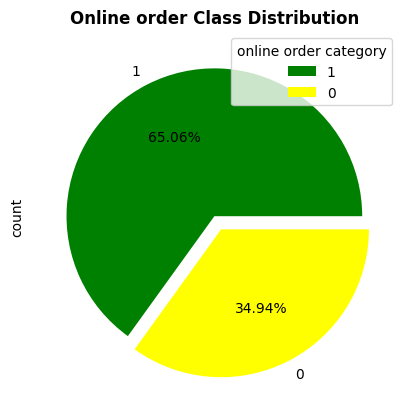

<Figure size 800x600 with 0 Axes>

In [28]:
data['online_order'].value_counts().plot(kind='pie', autopct='%.2f%%', explode=[0, 0.1], 
                                        colors=['green','Yellow'])
# Additional customizations
plt.title("Online order Class Distribution", weight='bold')
plt.legend(title='online order category', loc='upper right')
plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.show()

## **Data split**

### Seperating the matrix of features and dependent variable vector

In [29]:
X=data.drop(['fraud'],axis=1)
y=data['fraud']

### Splitting the dataset into train and test

In [30]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

### Feature Engineering

##### Scaling dataset

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
scaler=StandardScaler()
x_train_sc=scaler.fit_transform(x_train)
x_test_sc=scaler.transform(x_test)

In [108]:
x_train_sc

array([[-1.0398778 ,  1.15906515, -1.3792568 , ...,  1.36114699,
        -0.33463274,  0.73267685],
       [ 0.61204657, -0.30398681,  1.19555888, ...,  1.36114699,
        -0.33463274,  0.73267685],
       [ 1.17712323,  1.15906515, -1.22171963, ..., -0.73467451,
        -0.33463274,  0.73267685],
       ...,
       [-0.88392996,  1.15906515,  1.19555888, ...,  1.36114699,
        -0.33463274,  0.73267685],
       [ 1.17712323, -0.83260569, -1.44736536, ..., -0.73467451,
         2.98835073, -1.36485818],
       [ 1.17712323, -1.24434089,  1.19555888, ...,  1.36114699,
        -0.33463274,  0.73267685]])

### Displaying the shape of the features

In [41]:
print(x_train_sc.shape)
print(x_test_sc.shape)
print(y_train.shape)
print(y_test.shape)

(800000, 7)
(200000, 7)
(800000,)
(200000,)


## **Balancing the dataset using Smote**

In [32]:
smote=SMOTE(random_state=42)

### Making distribution of Target column equal

In [42]:
x_train_res,y_train_res=smote.fit_resample(x_train_sc,y_train)

### Shape of data after balancing

In [43]:
print(x_train_res.shape)
print((y_train_res.shape))

(1460156, 7)
(1460156,)


### Target column distribution after balancing the distribution of dataset

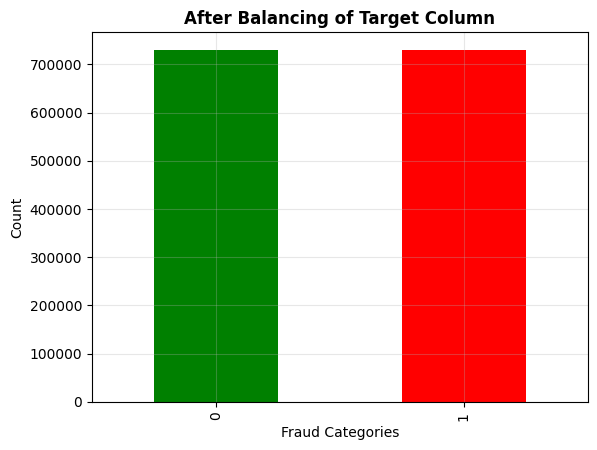

In [44]:
y_train_res.value_counts().plot(kind='bar',color=['green','red'])
plt.grid(alpha=0.3)
plt.title("After Balancing of Target Column",weight='bold')
plt.xlabel("Fraud Categories")
plt.ylabel('Count')
plt.show()

In [82]:
y_train_res.value_counts()

fraud
0    730078
1    730078
Name: count, dtype: int64

### Shape of data after balancing

In [45]:
print(x_train_res.shape)
print(y_train_res.shape)

(1460156, 7)
(1460156,)


## **Model Development**

#### Building Block box models

In [46]:
rf=RandomForestClassifier(random_state=42)
xgb=XGBClassifier()
gbc=GradientBoostingClassifier(random_state=42)

## **Training models**

##### Training Random Forest

In [47]:
rf.fit(x_train_res,y_train_res)

RandomForestClassifier(random_state=42)

##### Training Xgboost

In [50]:
xgb.fit(x_train_res,y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

##### Training Gradient Boosting model

In [51]:
gbc.fit(x_train_res,y_train_res)

GradientBoostingClassifier(random_state=42)

## **Model Evaluation**

#### Deriving Predictions

In [52]:
y_pred_rf=rf.predict(x_test_sc)
y_pred_xgb=xgb.predict(x_test_sc)
y_pred_gbc=gbc.predict(x_test_sc)

## Evaluating model via various metrics 

#### Evaluating random forest model

In [53]:
cm_rf=confusion_matrix(y_test,y_pred_rf)
cr_rf=classification_report(y_test,y_pred_rf)
acc_rf=accuracy_score(y_test,y_pred_rf)
pre_rf=precision_score(y_test,y_pred_rf)
re_rf=recall_score(y_test,y_pred_rf)
f1_rf=f1_score(y_test,y_pred_rf)

#### Evaluating random Gradient Boosting Model

In [54]:
cm_gbc=confusion_matrix(y_test,y_pred_gbc)
cr_gbc=classification_report(y_test,y_pred_gbc)
acc_gbc=accuracy_score(y_test,y_pred_gbc)
pre_gbc=precision_score(y_test,y_pred_gbc)
re_gbc=recall_score(y_test,y_pred_gbc)
f1_gbc=f1_score(y_test,y_pred_gbc)

#### Evaluating Xgboost-Classifier

In [55]:
cm_xgb=confusion_matrix(y_test,y_pred_xgb)
cr_xgb=classification_report(y_test,y_pred_xgb)
acc_xgb=accuracy_score(y_test,y_pred_xgb)
pre_xgb=precision_score(y_test,y_pred_xgb)
re_xgb=recall_score(y_test,y_pred_xgb)
f1_xgb=f1_score(y_test,y_pred_xgb)

## **Displaying Results**

#### **Result of Random Forest**

#### Accuracy and confusion matrix

Accuracy of Random-Forest: 0.829705


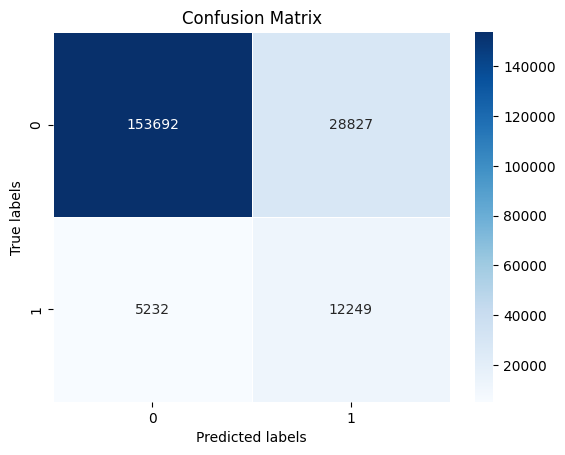

In [56]:
print("Accuracy of Random-Forest:",acc_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', linewidths=0.5)  
plt.xlabel('Predicted labels') 
plt.ylabel('True labels') 
plt.title('Confusion Matrix')  
plt.show()  


##### Precision, Recall and f1-score

In [57]:
print("Precision: Random Forest::",pre_rf)
print("Recall: Random Forest::",re_rf)
print("F1-score: Random Forest::",f1_rf)

Precision: Random Forest:: 0.2982033304119194
Recall: Random Forest:: 0.7007036210743093
F1-score: Random Forest:: 0.4183615963932579


#### Classification Report

In [58]:
print("Classification Report:\n",cr_rf)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.84      0.90    182519
           1       0.30      0.70      0.42     17481

    accuracy                           0.83    200000
   macro avg       0.63      0.77      0.66    200000
weighted avg       0.91      0.83      0.86    200000



#### **Result of Gradient Boosting**

#### Accuracy and confusion matrix

Accuracy of Gradient Boosting: 0.808585


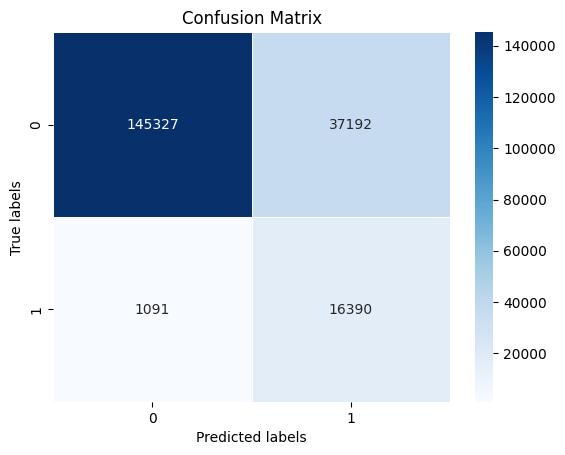

In [60]:
print("Accuracy of Gradient Boosting:",acc_gbc)
sns.heatmap(cm_gbc, annot=True, fmt='d', cmap='Blues', linewidths=0.5)  
plt.xlabel('Predicted labels') 
plt.ylabel('True labels') 
plt.title('Confusion Matrix')  
plt.show()  


##### Precision, Recall and f1-score

In [61]:
print("Precision: GradientBoosting::",pre_gbc)
print("Recall: GradientBoosting::",re_gbc)
print("F1-score: GradientBoosting::",f1_gbc)

Precision: GradientBoosting:: 0.3058863051024598
Recall: GradientBoosting:: 0.9375893827584234
F1-score: GradientBoosting:: 0.4612808353151429


#### Classification Report

In [62]:
print("Classification Report:\n",cr_gbc)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.88    182519
           1       0.31      0.94      0.46     17481

    accuracy                           0.81    200000
   macro avg       0.65      0.87      0.67    200000
weighted avg       0.93      0.81      0.85    200000



## **Result of Xgboost**

#### **Accuracy and Confusion matrix**

Accuracy of Xgboost: 0.8077


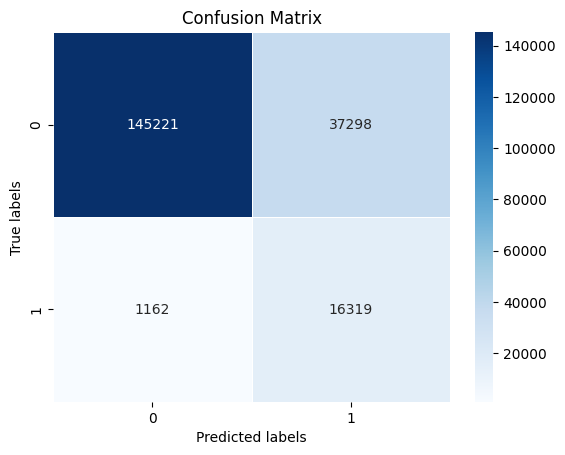

In [148]:
print("Accuracy of Xgboost:", acc_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', linewidths=0.5)  
plt.xlabel('Predicted labels') 
plt.ylabel('True labels') 
plt.title('Confusion Matrix')  
plt.show()  

##### Precision, Recall and f1-score

In [151]:
print("Precision: Xgboost::",pre_xgb)
print("Recall: Xgboost::",re_xgb)
print("F1-score: Xgboost::",f1_xgb)

Precision: Xgboost:: 0.3043624223660406
Recall: Xgboost:: 0.9335278302156628
F1-score: Xgboost:: 0.4590565135446848


#### Classification Report

In [150]:
print("Classification Report:\n",cr_xgb)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.88    182519
           1       0.30      0.93      0.46     17481

    accuracy                           0.81    200000
   macro avg       0.65      0.86      0.67    200000
weighted avg       0.93      0.81      0.85    200000



### Hyperparameters

In [44]:
param_grid = { 
    'n_estimators': [25, 50, 150], 
    'max_features': ['sqrt',0.75, None], 
    'max_depth': [ 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
} 

### Specifying parameters

In [46]:
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
                           param_grid=param_grid,cv=5,scoring='accuracy') 

### Training Grid Search CV model

In [47]:
grid_search.fit(x_train_res, y_train_res) 

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [6, 9],
                         'max_features': ['sqrt', 0.75, None],
                         'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 150]},
             scoring='accuracy')

### Getting best hyperparameters

In [48]:
print(grid_search.best_estimator_) 

RandomForestClassifier(max_depth=6, max_leaf_nodes=9, n_estimators=50,
                       random_state=42)


### Deriving the best model from the Grid_search

In [49]:
best_model=grid_search.best_estimator_

### Training Best model

In [50]:
best_model.fit(x_train_res,y_train_res)

RandomForestClassifier(max_depth=6, max_leaf_nodes=9, n_estimators=50,
                       random_state=42)

In [51]:
y_pred_best=best_model.predict(x_test_sc)

### saving the model

In [52]:
import pickle
pickle.dump(best_model,open("best_model.pkl",'wb'))

### Evaluating the performance of the best model

In [53]:
cm_rff=confusion_matrix(y_test,y_pred_best)
cr_rff=classification_report(y_test,y_pred_best)
acc_rff=accuracy_score(y_test,y_pred_best)
pre_rff=precision_score(y_test,y_pred_best)
re_rff=recall_score(y_test,y_pred_best)
f1_rff=f1_score(y_test,y_pred_best)

### Displaying results

In [55]:
print("Confusion_matrix:\n",cm_rff)
print("Classificatin_report:\n",cr_rff)
print("Accuracy of best model:",acc_rff)
print("Precision:",pre_rff)
print("Recall:",re_rff)
print("F1_score:",f1_rff)

Confusion_matrix:
 [[145332  37187]
 [  1091  16390]]
Classificatin_report:
               precision    recall  f1-score   support

           0       0.99      0.80      0.88    182519
           1       0.31      0.94      0.46     17481

    accuracy                           0.81    200000
   macro avg       0.65      0.87      0.67    200000
weighted avg       0.93      0.81      0.85    200000

Accuracy of best model: 0.80861
Precision: 0.30591485152210834
Recall: 0.9375893827584234
F1_score: 0.4613132933659827


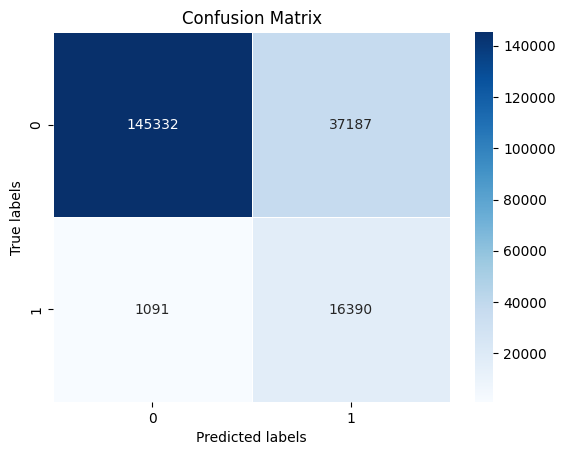

In [58]:
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', linewidths=0.5)  
plt.xlabel('Predicted labels') 
plt.ylabel('True labels') 
plt.title('Confusion Matrix')  
plt.show()  

##### Saving best model

In [63]:
import pickle
best_model=pickle.load(open('best_model.pkl', 'rb'))

### Important features of the best model

In [152]:
best_model.feature_importances_

array([0.0855207 , 0.00468941, 0.49861632, 0.01211156, 0.04178842,
       0.07553178, 0.28174182])

### Model explainability using the Feature_importances_ attribute of the best tunned model

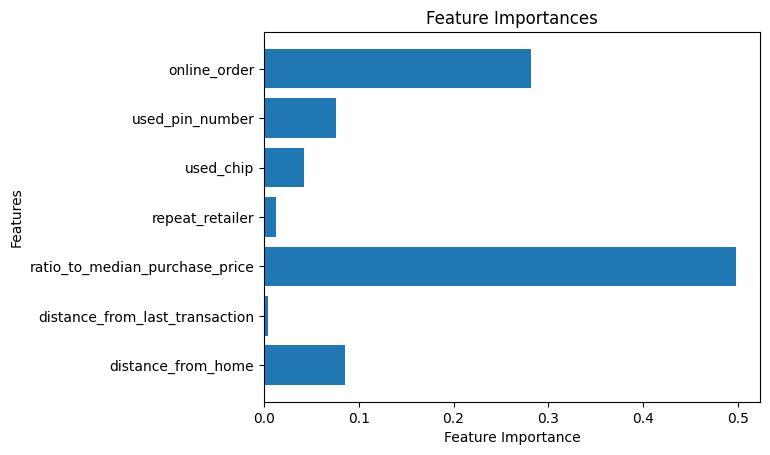

In [153]:
importances = best_model.feature_importances_
feature_names = cols
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

In [97]:
# pip install shap

### Explainability of the Machine learning Model using SHAP

In [98]:
import shap

#### Setting up SHAP Explainer

### Using the explainer to explain predictions

## Summary Plot
**The summary plot shows the feature importance of each feature in the model. The results show that “Status,” “Complaints,” and “Frequency of use” play major roles in determining the results**

In [136]:
# Fits the explainer
explainer = shap.Explainer(best_model.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)

ExactExplainer explainer: 200001it [46:41, 71.27it/s]                             


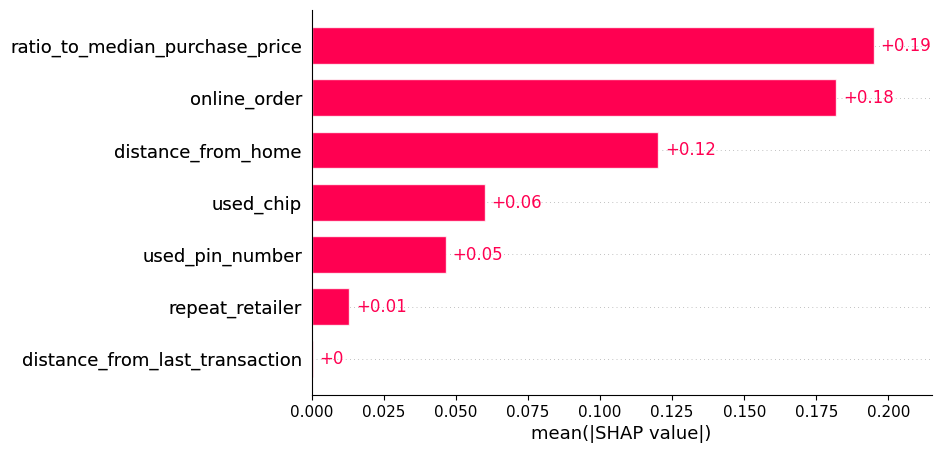

In [139]:
shap.plots.bar(shap_values)

#### behaviour on ist prediction

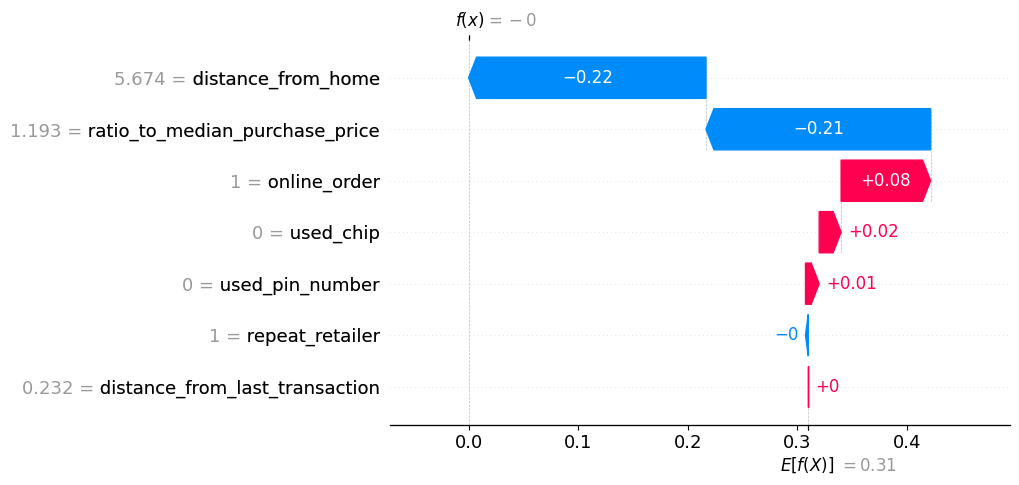

In [145]:
shap.plots.waterfall(shap_values[0])

In [147]:
shap.plots.force(shap_values[0])